  # Test of hierarchical classification (model 2)
  
  This model uses four layers. In the first layer, every source is classified hierarchically as Stochastic, Transient or Periodic. Then, every source pass trough the next layers (Stochastic, Transient and Periodic). The final classification is dertermined by multiplying the probabilities of the first layer, with their correspondant probabilites of the Stochastic, Transient and Periodic layers. For instance, the probability of being RRL corresponds to the product of the probability of being periodic (according to the first layer) and the probability of being RRL (according to the periodic layer): 
 
 $$Prob_{final}(RRL) = Prob_{first \: layer}(Periodic)* Prob_{periodic \: layer}(RRL)$$
 
 And the probability of being a Blazar is computed as:
 
  $$Prob_{final}(Blazar) = Prob_{first \: layer}(Stochastic)* Prob_{stochastic \: layer}(Blazar)$$


 
 The final classification is definded by the maximum $Prob_{final}$
 


In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier



  ### Definition of names for plots and files

In [2]:
morethan5 = False

date = '20190925'

#names of files with detections, features and labels for the training set (v3)
labels_file = '../alerce_trainingset/training_set_v3/labels.pkl'
detections_file = '../alerce_trainingset/training_set_v3/detections.pkl'
#features_file = '../alerce_trainingset/training_set_v3/features.pkl'
features_file = '../ZTF_data/features_20190926.pickle'
non_detections_file = '../alerce_trainingset/training_set_v3/training_non_det_v3.h5'

early_probs = '../ZTF_data/gaia_parallaxes.csv'

class_output = '../ZTF_classifications/classification_unlabelled_set_20190926.csv'

#where the RF models are saved
if morethan5:
    model_first_layer = 'stat_prob_hierRF_model_2/rf_model_2_hierarchical_layer_morethan5gr_'+date
    model_periodic_layer = 'stat_prob_hierRF_model_2/rf_model_2_periodic_layer_morethan5gr_'+date
    model_transient_layer = 'stat_prob_hierRF_model_2/rf_model_2_transient_layer_morethan5gr_'+date
    model_stochastic_layer = 'stat_prob_hierRF_model_2/rf_model_2_stochastic_layer_morethan5gr_'+date

else: 
    model_first_layer = 'stat_prob_hierRF_model_2/rf_model_2_hierarchical_layer_'+date
    model_periodic_layer = 'stat_prob_hierRF_model_2/rf_model_2_periodic_layer_'+date
    model_transient_layer = 'stat_prob_hierRF_model_2/rf_model_2_transient_layer_'+date
    model_stochastic_layer = 'stat_prob_hierRF_model_2/rf_model_2_stochastic_layer_'+date

#confusion matrixes
if morethan5:
    conf_matrix_name_first_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_hierarchical_layer_morethan5gr_'+date
    conf_matrix_name_second_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_multiclass_morethan5gr_'+date

else:
    conf_matrix_name_first_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_hierarchical_layer_'+date
    conf_matrix_name_second_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_multiclass_'+date


#feature importances
if morethan5:
    feature_importance_name_first_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_hierarchical_layer_morethan5gr_'+date
    feature_importance_name_periodic_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_periodic_layer_morethan5gr_'+date
    feature_importance_name_transient_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_transient_layer_morethan5gr_'+date
    feature_importance_name_stochastic_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_stochastic_layer_morethan5gr_'+date
    
else: 
    feature_importance_name_first_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_hierarchical_layer_'+date
    feature_importance_name_periodic_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_periodic_layer_'+date
    feature_importance_name_transient_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_transient_layer_'+date
    feature_importance_name_stochastic_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_stochastic_layer_'+date

### reading the training set files 

In [3]:
df_nd = pd.read_hdf(non_detections_file)
df_feat = pd.read_pickle(features_file)
df_labels = pd.read_pickle(labels_file)
df_detections = pd.read_pickle(detections_file)

df_early_probs = pd.read_csv(early_probs,index_col='oid')

#deleting columns in df_nd with name ending in "_3"
#for col in list(df_nd):
#    if col[-2:] == "_3":
#        df_nd.drop(col, inplace=True, axis=1)

#getting gscore from the detections file
#df_det = df_detections.groupby(['oid'])
#df_sgscore = df_det['sgscore1'].median()
#df_sgscore = df_sgscore.to_frame()

#creating color features
#df_nd["g_r_max"] = df_nd.min_mag_fid_1 - df_nd.min_mag_fid_2
#df_feat["g_r_mean"] = df_feat.Mean_1 - df_feat.Mean_2

#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

df_early_probs.head()

,parallax,parallax_error
oid,,
ZTF19aazdwgv,1.042462,0.040738
ZTF19aazdwfx,1.812311,0.346394
ZTF19aazdwli,NaN,NaN
ZTF18abtdmue,1.649289,0.037605
ZTF17aaanqyq,0.766195,0.055493


In [4]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
df_labels.loc[(df_labels['class_source'] == 'RS CVn'), 'class_original'] = 'RS-CVn'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'

#defining the classes included in the RF model
label_order = ['AGN-I', 'Blazar', 'CV/Nova', 'SNIa', 'SNIbc', 'SNII',
               'SLSN', 'EBSD/D', 'EBC', 'DSCT', 'RRL', 'Ceph', 'RS-CVn', 'LPV','Periodic-Other']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

#defining hierarchical classes:

labels['class_hierachical'] = labels['class_original']

labels.loc[(labels['class_hierachical'] == 'RS-CVn') | (labels['class_hierachical'] == 'EBSD/D') | (labels['class_hierachical'] == 'EBC')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'Ceph')  | (labels['class_hierachical'] == 'Periodic-Other') , 'class_hierachical'] = 'Periodic'

labels.loc[(labels['class_hierachical'] == 'SNIa') | (labels['class_hierachical'] == 'SNIbc') | (labels['class_hierachical'] == 'SNII') | (labels['class_hierachical'] == 'SLSN'), 'class_hierachical'] = 'Transient'

labels.loc[ (labels['class_hierachical'] == 'CV/Nova')| (labels['class_hierachical'] == 'AGN-I') | (labels['class_hierachical'] == 'Blazar')  | (labels['class_hierachical'] == 'LPV') , 'class_hierachical'] = 'Stochastic'

cm_classes_hierachical = ['Stochastic','Transient','Periodic']
cm_classes_original = label_order

labels.head()

,class_original,class_hierachical
oid,,
ZTF17aacjwvd,EBSD/D,Periodic
ZTF17aadecrr,EBSD/D,Periodic
ZTF18adaksvf,RS-CVn,Periodic
ZTF18abtqdih,EBC,Periodic
ZTF18abshynt,LPV,Stochastic


In [5]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_fid_1',
'n_det_fid_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',]
'''
'max_mjd_fid_1',
'max_mjd_fid_2',
'min_mjd_fid_1',
'min_mjd_fid_2',
'max_mag_fid_1',
'max_mag_fid_2',
'min_mag_fid_1',
'min_mag_fid_2',
'first_mag_fid_1',
'first_mag_fid_2',
'first_mjd_fid_1',
'first_mjd_fid_2']
'''

#combining all the DF
#df = labels.join(df_sgscore).join(df_feat).join(df_nd.drop(rm_nd_cols, axis=1))
#df = labels.join(df_sgscore).join(df_feat.drop(rm_nd_cols, axis=1))
df = labels.join(df_early_probs).join(df_feat.drop(rm_nd_cols, axis=1))
df_train = df
df_train.fillna(-999,inplace=True)
df.drop(['Mean_1', 'Mean_2','class_original','class_hierachical'], axis=1, inplace=True)
df.fillna(-999,inplace=True)
labels = labels.loc[df.index.values]

if morethan5:
    df = df[(df.n_samples_1 > 5) & (df.n_samples_2 > 5)]
    labels = labels.loc[df.index.values]

df.head()

,parallax,parallax_error,delta_mag_fid_1,delta_mag_fid_2,delta_mjd_fid_1,delta_mjd_fid_2,dmag_first_det_fid_1,dmag_first_det_fid_2,dmag_non_det_fid_1,dmag_non_det_fid_2,...,Pvar_2,ExcessVar_2,SF_ML_amplitude_2,SF_ML_gamma_2,GP_DRW_sigma_2,GP_DRW_tau_2,IAR_phi_2,LinearTrend_2,gal_b,gal_l
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaajz,-999.000000,-999.000000,-999.000000,0.596987,-999.000000,341.086539,-999.000000,3.167515,-999.000000,4.103239,...,1.0,0.000040,0.236497,0.264988,0.026484,70.525797,0.974142,-0.000433,-1.456907,150.428061
ZTF17aaaaaly,0.015727,0.120408,0.238337,0.703848,28.954132,404.922488,1.267601,4.699041,1.291203,4.843677,...,1.0,0.000102,0.323060,0.310910,0.035095,202.837050,0.992708,-0.000178,0.651815,92.316357
ZTF17aaaaanx,0.179945,0.082161,-999.000000,0.799698,-999.000000,320.976238,-999.000000,4.836487,-999.000000,5.129286,...,1.0,0.000314,0.586396,0.259243,0.079996,82.304754,0.988186,0.000643,-2.099886,89.671164
ZTF17aaaaasi,-0.160446,0.191406,6.780998,5.154176,470.760984,460.777373,-999.000000,-999.000000,-999.000000,-999.000000,...,1.0,0.011850,0.000000,0.000000,1.181572,895.110137,0.999453,-0.008314,-5.405982,90.934944
ZTF17aaaaast,0.161503,0.061450,1.308856,0.855596,429.759028,450.728380,0.000660,3.864022,2.376453,4.634753,...,1.0,0.000355,0.800532,0.555077,0.081686,308.878450,0.996715,-0.001070,-2.785845,88.361459


  ### Defining functions to plot the confusion matrix and the feature importance

In [6]:
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    if morethan5: title='Confusion matrix for more than 5 samples per band'

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    
    
def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(model.feature_importances_))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name)
    #plt.close()

### Pre-processing training data

In [7]:
Y_hierarchical = labels['class_hierachical']#.values
Y_original = labels['class_original']#.values

X_hierarchical = df#.columns.values.tolist()

#splitting training set
X_train_hierarchical, X_test_hierarchical, y_train_hierarchical, y_test_hierarchical, y_train_original, y_test_original  = model_selection.train_test_split(X_hierarchical,
Y_hierarchical, Y_original, test_size=0.2, stratify=Y_original)


# separating training sets for sub-classes
X_train_periodic = X_train_hierarchical.loc[y_train_hierarchical=='Periodic', :]
y_train_periodic = y_train_original.loc[y_train_hierarchical=='Periodic']

X_train_stochastic = X_train_hierarchical.loc[y_train_hierarchical=='Stochastic', :]
y_train_stochastic = y_train_original.loc[y_train_hierarchical=='Stochastic']

X_train_transient = X_train_hierarchical.loc[y_train_hierarchical=='Transient', :]
y_train_transient = y_train_original.loc[y_train_hierarchical=='Transient']

print(len(y_train_periodic), len(y_train_stochastic), len(y_train_transient))

40714 27646 756


  ## Balanced random forest
  
  ### First layer: separating Periodic, Stochastic and Transients:

In [8]:
#Training first layer of the RF model

rf_model_hierarchical = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=1,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_hierarchical.fit(X_train_hierarchical, y_train_hierarchical)

#testing first layer performance

y_true, y_pred = y_test_hierarchical, rf_model_hierarchical.predict(X_test_hierarchical)
y_pred_proba_hier = rf_model_hierarchical.predict_proba(X_test_hierarchical)

classes_order_proba_hierarchical = rf_model_hierarchical.classes_
print(classes_order_proba_hierarchical)

#c = np.c_[y_pred_proba_hier, y_test_original]
#c = np.c_[c, y_pred_]
#print(c)

print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true, y_pred))

#Dumping trained model

features_hierarchical = list(X_hierarchical)

with open(model_first_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_hierarchical,
            'features': features_hierarchical,
            'order_classes': classes_order_proba_hierarchical
            }
        pickle.dump(model_dump, pickle_file)

['Periodic' 'Stochastic' 'Transient']
Accuracy: 0.9716435185185185
Balanced accuracy: 0.9795142945735617


[[6737   40  135]
 [   1  188    0]
 [ 313    1 9865]]
Normalized confusion matrix


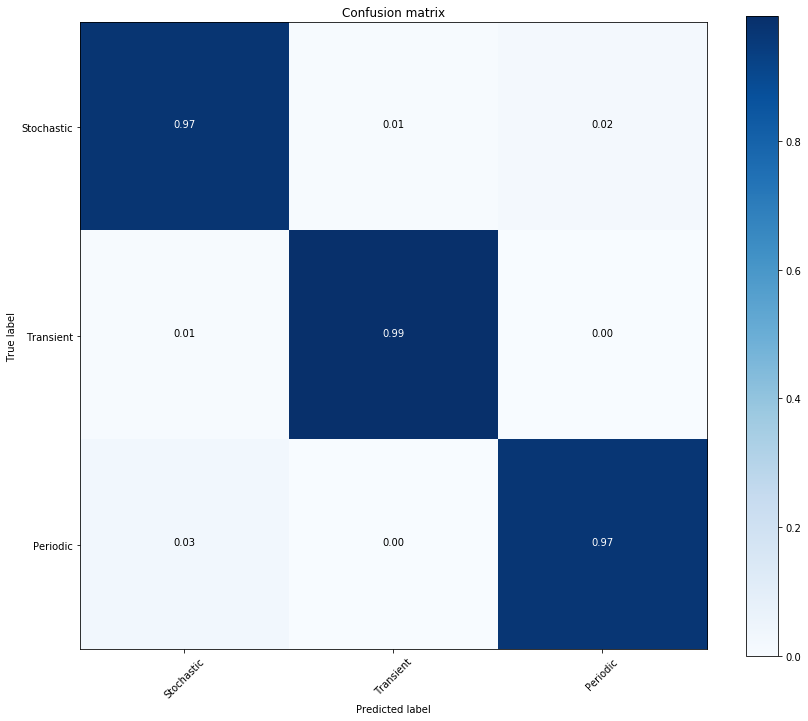

In [9]:
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=cm_classes_hierachical)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,cm_classes_hierachical,conf_matrix_name_first_layer)

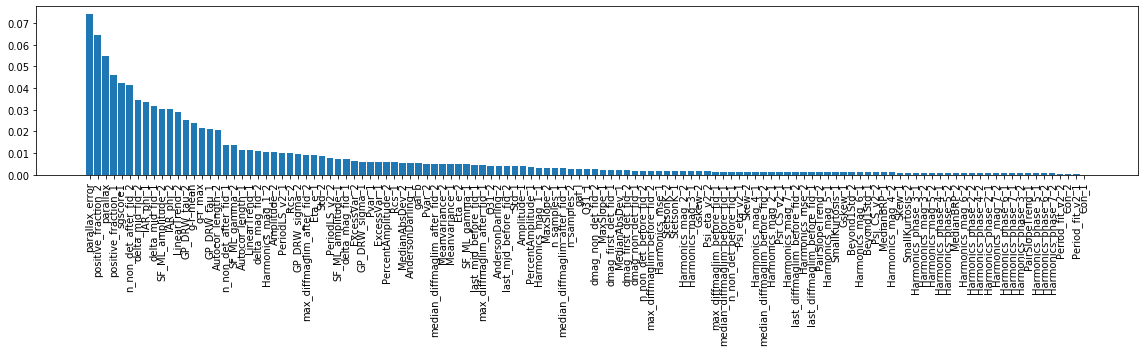

In [10]:
#plotting feature importance
plot_feature_importances(rf_model_hierarchical, features_hierarchical, feature_importance_name_first_layer)

  ### Periodic layer

In [11]:
#Training Periodic layer

rf_model_periodic = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=1,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_periodic.fit(X_train_periodic, y_train_periodic)

# Applying periodic model to the test data
y_true_periodic, y_pred_periodic = y_test_original, rf_model_periodic.predict(X_test_hierarchical)
y_pred_proba_periodic = rf_model_periodic.predict_proba(X_test_hierarchical)

classes_order_proba_periodic = rf_model_periodic.classes_
print(classes_order_proba_periodic)

#Dumping trained model

features_periodic = list(X_train_periodic)

with open(model_periodic_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_periodic,
            'features': features_periodic,
            'order_classes': classes_order_proba_periodic
            }
        pickle.dump(model_dump, pickle_file)

['Ceph' 'DSCT' 'EBC' 'EBSD/D' 'Periodic-Other' 'RRL' 'RS-CVn']


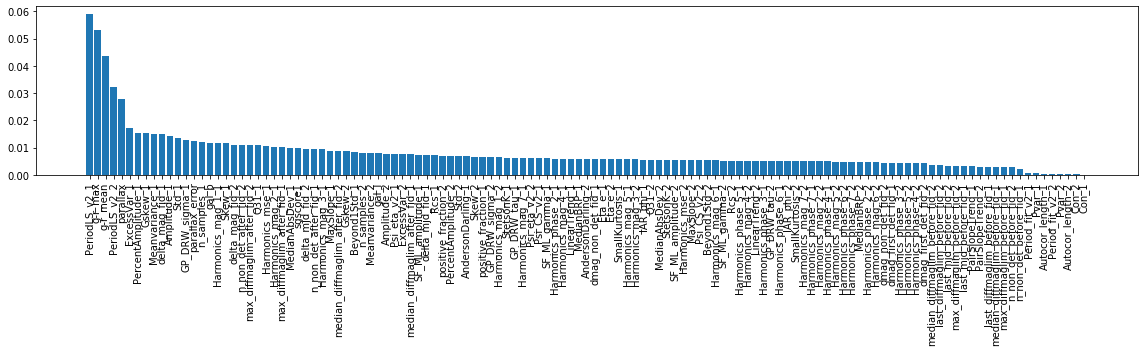

In [12]:
#plotting feature importance
plot_feature_importances(rf_model_periodic, features_hierarchical, feature_importance_name_first_layer)

  ### Stochastic layer

In [13]:
#Training Stochastic layer

rf_model_stochastic = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=1,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_stochastic.fit(X_train_stochastic, y_train_stochastic)

# Applying stochastic model to the test data
y_true_stochastic, y_pred_stochastic  = y_test_original, rf_model_stochastic.predict(X_test_hierarchical)
y_pred_proba_stochastic = rf_model_stochastic.predict_proba(X_test_hierarchical)

classes_order_proba_stochastic = rf_model_stochastic.classes_
print(classes_order_proba_stochastic)

#Dumping trained model

features_stochastic = list(X_train_stochastic)

with open(model_stochastic_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_stochastic,
            'features': features_stochastic,
            'order_classes': classes_order_proba_stochastic
            }
        pickle.dump(model_dump, pickle_file)

['AGN-I' 'Blazar' 'CV/Nova' 'LPV']


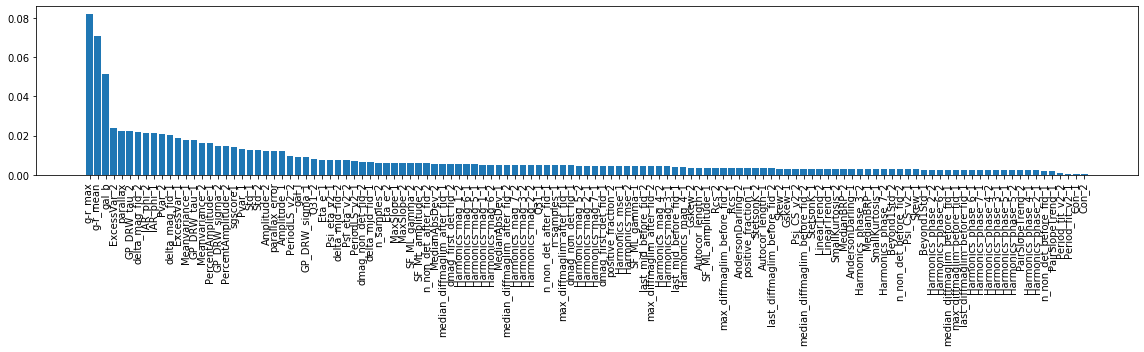

In [14]:
#plotting feature importance
plot_feature_importances(rf_model_stochastic, features_stochastic, feature_importance_name_stochastic_layer)

  ### Transient layer

In [15]:
#Training Transient layer

rf_model_transient = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=1,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_transient.fit(X_train_transient, y_train_transient)

# Applying transient model to the test data
y_true_transient, y_pred_transient  = y_test_original, rf_model_transient.predict(X_test_hierarchical)
y_pred_proba_transient = rf_model_transient.predict_proba(X_test_hierarchical)

classes_order_proba_transient = rf_model_transient.classes_
print(classes_order_proba_transient)

#Dumping trained model

features_transient = list(X_train_transient)

with open(model_transient_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_transient,
            'features': features_transient,
            'order_classes': classes_order_proba_transient
            }
        pickle.dump(model_dump, pickle_file)

['SLSN' 'SNII' 'SNIa' 'SNIbc']


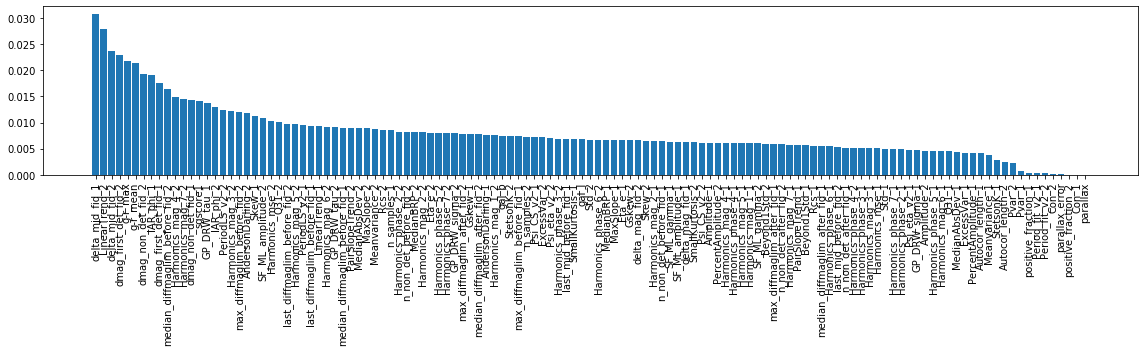

In [16]:
#plotting feature importance
plot_feature_importances(rf_model_transient, features_transient, feature_importance_name_transient_layer)

 ## Putting al layers together  


In [17]:
# generating final probabilities

#multiplying probabilities of the hierarchical layer with the other layers
prob_periodic = y_pred_proba_periodic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
prob_stochastic = y_pred_proba_stochastic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
prob_trainsient = y_pred_proba_transient*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final = np.concatenate((prob_stochastic,prob_trainsient,prob_periodic),axis=1)

print(np.sum(prob_final,axis=1),np.mean(np.sum(prob_final,axis=1)),np.std(np.sum(prob_final,axis=1)))

#getting the ordered name of classes for prob_final
prob_final_class_names = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
print(prob_final_class_names)


class_final_proba = np.amax(prob_final,axis=1)
class_final_index = np.argmax(prob_final,axis=1)
class_final_name = [prob_final_class_names[x] for x in class_final_index]



[1. 1. 1. ... 1. 1. 1.] 1.0 9.778489413088926e-17
['AGN-I' 'Blazar' 'CV/Nova' 'LPV' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'Ceph'
 'DSCT' 'EBC' 'EBSD/D' 'Periodic-Other' 'RRL' 'RS-CVn']


[[1706  267   11    0    2    3   10    0    0    3    3    1    0    8
     1]
 [  38  100   19    0    0    0    2    0    1    0    4    0    0    2
     1]
 [   4   11   88    3    3    0    2    1    6   13    7    6    1    4
     6]
 [   0    0    0   88   35    5   11    0    0    0    0    0    0    0
     0]
 [   0    0    0    3    3    2    1    0    0    0    0    0    0    0
     0]
 [   0    1    0    8    0   15   13    0    0    0    0    0    0    0
     0]
 [   1    0    0    0    0    0    3    0    0    0    0    0    0    0
     0]
 [ 132   93   56    0    0    0    0 2038 1079  374   89  118  519   25
   637]
 [  27   27   18    0    0    0    0  239  636  100   32   39   88   16
   167]
 [   2    1    1    0    0    0    0    5    3  106    7    0    3    2
     7]
 [  64   52   15    0    0    1    0   56   47  165 2457   76   15    7
   211]
 [   0    5    1    0    0    0    0    0    2    0   18   76    8    3
     5]
 [   4    9    0    0    0    0    0    

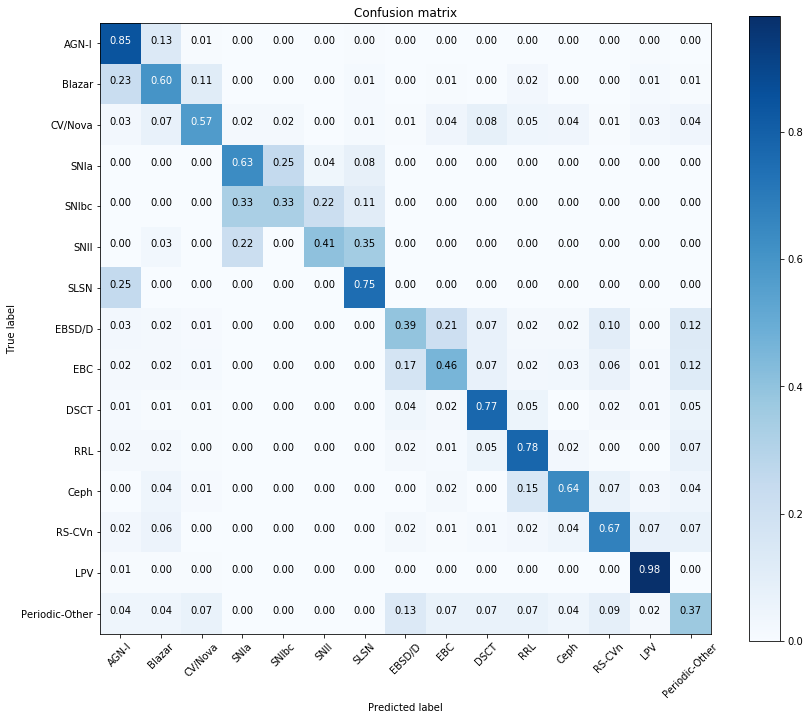

In [18]:
# generating confusion matrix for multilabels
cnf_matrix = metrics.confusion_matrix(y_test_original, class_final_name,labels=label_order)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,label_order, conf_matrix_name_second_layer)

print("Accuracy:", metrics.accuracy_score(y_test_original, class_final_name))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test_original, class_final_name))

In [19]:
# Kaggle score

num_y_test =  [np.where(prob_final_class_names==x)[0][0] for x in y_test_original] #label_encoder.transform(y_test)

#print(num_y_test)

CLASSES_REDUCED_V2 = prob_final_class_names

def kaggle_loss(labels, predictions, weights=None):
    np.clip(predictions, 10**-15, 1-10**-15, out=predictions)
    classes = np.unique(labels)
    if weights is None:
        weights = np.ones(len(classes), dtype=np.float64)/len(classes)
    loss_sum = 0
    labels = np.array(labels)
    for i in classes:
        p = predictions[labels == i, i]
        class_score = np.mean(np.log(p))*weights[i]
        print(CLASSES_REDUCED_V2[i], class_score)
        loss_sum += class_score
    return -loss_sum/sum(weights)



print(kaggle_loss(num_y_test,prob_final))

AGN-I -0.04535007135467989
Blazar -0.07643617273188982
CV/Nova -0.10129723585420834
LPV -0.01895541321871338
SLSN -0.07897527682405985
SNII -0.09199928749404104
SNIa -0.07480797755774589
SNIbc -0.09083696997601402
Ceph -0.07559192085612898
DSCT -0.06867923151926827
EBC -0.10175901885610762
EBSD/D -0.10421697051202876
Periodic-Other -0.12092696076641299
RRL -0.06761708062873235
RS-CVn -0.09678646229313681
1.2142360504431682


  ## Analysis post classification in training set

In [20]:
oids_test = y_test_original.index.values
classified_names = np.array(class_final_name)

LPV_asAGN = oids_test[np.where((y_test_original.values=='SNII') & (classified_names=='Blazar'))]

print(LPV_asAGN) 

['ZTF19aawlgne']


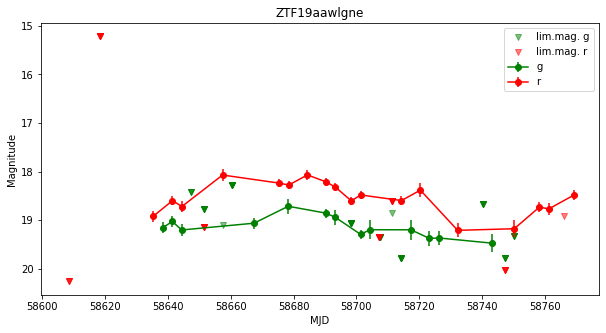

In [21]:

import psycopg2
import json

credentials_file = "alercereaduser.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]
    

conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])
    
    
def plotLC(oid, SN_det, SN_nondet):
    fig, ax = plt.subplots(figsize = (10, 5))
    labels = {1: 'g', 2: 'r'}
    colors = {1: 'g', 2: 'r'}
    for fid in [1, 2]:
        mask = SN_det.fid == fid
        if np.sum(mask) > 0:            
            ax.errorbar(SN_det[mask].mjd, SN_det[mask].magpsf_corr, 
                yerr = SN_det[mask].sigmapsf_corr, c = colors[fid], marker = 'o', label = labels[fid])
        mask = (SN_nondet.fid == fid) & (SN_nondet.diffmaglim > -900)
        if np.sum(mask) > 0:            
            ax.scatter(SN_nondet[mask].mjd, SN_nondet[mask].diffmaglim, c = colors[fid], alpha = 0.5,
                marker = 'v', label = "lim.mag. %s" % labels[fid])
    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("Magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])
    
    
def getSNdata(oid, doplot = False, doNED = False):

    # query detections and sort by mjd
    query="select oid, ra, dec, fid, mjd, magpsf_corr, sigmapsf_corr from detections where oid='%s'" % oid
    SN_det = pd.read_sql_query(query, conn)
    SN_det.sort_values(by=['mjd'], inplace=True)
        
    # query non detections and sort by mjd
    query="select oid, fid, mjd, diffmaglim from non_detections where oid='%s'" % oid
    SN_nondet = pd.read_sql_query(query, conn)
    SN_nondet.sort_values(by=['mjd'], inplace=True)
    
    if doplot:
        plotLC(oid, SN_det, SN_nondet)
        
    # find NED galaxies
    if doNED:
        co = coordinates.SkyCoord(ra=SNe.meanra[oid], dec=SNe.meandec[oid], unit=(u.deg, u.deg), frame='fk4')
        result_table = Ned.query_region(co, radius=0.01 * u.deg, equinox='J2000.0')
        display(result_table)
                
    # return data
    return SN_det, SN_nondet


for oid in LPV_asAGN:
    getSNdata(oid, doplot = True, doNED = False);

  ## Classifying unlabeled data

In [22]:
#loading the data

rm_nd_cols = ['n_det_fid_1', 'n_det_fid_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2',
             'Mean_1', 'Mean_2']

df_feat_ul = df_feat.drop(rm_nd_cols, axis=1)

df_feat_ul = df_feat_ul.join(df_early_probs)
df_feat_ul.fillna(-999,inplace=True)


df_feat_ul.head()

,delta_mag_fid_1,delta_mag_fid_2,delta_mjd_fid_1,delta_mjd_fid_2,dmag_first_det_fid_1,dmag_first_det_fid_2,dmag_non_det_fid_1,dmag_non_det_fid_2,g-r_max,g-r_mean,...,SF_ML_amplitude_2,SF_ML_gamma_2,GP_DRW_sigma_2,GP_DRW_tau_2,IAR_phi_2,LinearTrend_2,gal_b,gal_l,parallax,parallax_error
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaaal,0.032629,0.254983,328.988576,277.145220,4.519737,-999.000000,3.994130,-999.000000,0.858481,0.740361,...,0.139834,-0.010706,0.009336,1.189284,5.090650e-01,-0.000046,-2.113665,150.836431,-999.0,-999.0
ZTF17aaaaaam,-999.000000,0.226419,-999.000000,295.111979,-999.000000,3.979172,-999.000000,3.678471,-999.000000,-999.000000,...,0.083609,-0.063594,0.004067,7.282321,8.556124e-01,0.000131,-2.308571,151.324459,-999.0,-999.0
ZTF17aaaaaan,0.585472,0.517434,406.954931,382.938519,3.734895,-999.000000,3.983608,-999.000000,0.505881,0.506067,...,0.218346,0.027628,0.021402,0.002910,4.230063e-13,0.000186,-3.562309,156.195108,-999.0,-999.0
ZTF17aaaaaao,0.490560,0.494049,407.000139,377.003113,-999.000000,-999.000000,-999.000000,-999.000000,0.888514,0.893602,...,0.261934,-0.008325,0.034537,1.682574,5.627946e-01,-0.000039,-3.847878,156.135686,-999.0,-999.0
ZTF17aaaaaas,0.868894,0.632318,401.960451,365.980463,-999.000000,-999.000000,-999.000000,-999.000000,0.840038,0.787097,...,0.312031,0.111044,0.032522,3.943487,8.126489e-01,0.000840,0.933258,155.698148,-999.0,-999.0


In [23]:
#predicting classes of unlabeled data



test_Y_hierarchical = rf_model_hierarchical.predict(df_feat_ul)
test_Y_proba_hierarchical = rf_model_hierarchical.predict_proba(df_feat_ul)

test_Y_periodic = rf_model_periodic.predict(df_feat_ul)
test_Y_proba_periodic = rf_model_periodic.predict_proba(df_feat_ul)

test_Y_stochastic = rf_model_stochastic.predict(df_feat_ul)
test_Y_proba_stochastic = rf_model_stochastic.predict_proba(df_feat_ul)

test_Y_transient = rf_model_transient.predict(df_feat_ul)
test_Y_proba_transient = rf_model_transient.predict_proba(df_feat_ul)


#multiplying probabilities
prob_periodic_ul = test_Y_proba_periodic*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
prob_stochastic_ul = test_Y_proba_stochastic*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
prob_trainsient_ul = test_Y_proba_transient*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final_ul = np.concatenate((prob_stochastic_ul,prob_trainsient_ul,prob_periodic_ul),axis=1)

print(np.sum(prob_final_ul,axis=1),np.mean(np.sum(prob_final_ul,axis=1)),np.std(np.sum(prob_final_ul,axis=1)))

#getting the ordered name of classes for prob_final
prob_final_class_names_ul = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
print(prob_final_class_names)


class_final_proba_ul = np.amax(prob_final_ul,axis=1)
class_final_index_ul = np.argmax(prob_final_ul,axis=1)
class_final_name_ul = [prob_final_class_names_ul[x] for x in class_final_index_ul]


[1. 1. 1. ... 1. 1. 1.] 1.0 1.175267782866358e-16
['AGN-I' 'Blazar' 'CV/Nova' 'LPV' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'Ceph'
 'DSCT' 'EBC' 'EBSD/D' 'Periodic-Other' 'RRL' 'RS-CVn']


In [25]:
#Writing results in the output

df_out = df_feat_ul
print(df_out.shape)
print(len(class_final_name_ul))
print(len(prob_final_ul))


df_out['predicted_class'] = class_final_name_ul
df_out['predicted_class_proba'] = class_final_proba_ul


probs_header = prob_final_class_names_ul + '_prob'

prob_pd_ul = pd.DataFrame(prob_final_ul,columns=probs_header,index=df_out.index)

prob_h_pd_ul = pd.DataFrame(test_Y_proba_hierarchical, columns=['prob_Periodic','prob_Stochastic','prob_Transient'],index=df_out.index)

test_data_withclass = df_out.join(prob_pd_ul).join(prob_h_pd_ul)

test_data_withclass.to_csv(class_output)

test_data_withclass.head()


(766019, 125)
766019
766019


,delta_mag_fid_1,delta_mag_fid_2,delta_mjd_fid_1,delta_mjd_fid_2,dmag_first_det_fid_1,dmag_first_det_fid_2,dmag_non_det_fid_1,dmag_non_det_fid_2,g-r_max,g-r_mean,...,Ceph_prob,DSCT_prob,EBC_prob,EBSD/D_prob,Periodic-Other_prob,RRL_prob,RS-CVn_prob,prob_Periodic,prob_Stochastic,prob_Transient
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaaal,0.032629,0.254983,328.988576,277.145220,4.519737,-999.000000,3.994130,-999.000000,0.858481,0.740361,...,0.027056,0.010336,0.027360,0.018240,0.031312,0.021280,0.016416,0.152,0.500,0.348
ZTF17aaaaaam,-999.000000,0.226419,-999.000000,295.111979,-999.000000,3.979172,-999.000000,3.678471,-999.000000,-999.000000,...,0.019716,0.009300,0.030504,0.023436,0.048732,0.007812,0.046500,0.186,0.546,0.268
ZTF17aaaaaan,0.585472,0.517434,406.954931,382.938519,3.734895,-999.000000,3.983608,-999.000000,0.505881,0.506067,...,0.022680,0.009720,0.029160,0.024948,0.038880,0.017172,0.019440,0.162,0.510,0.328
ZTF17aaaaaao,0.490560,0.494049,407.000139,377.003113,-999.000000,-999.000000,-999.000000,-999.000000,0.888514,0.893602,...,0.024708,0.011928,0.022720,0.017608,0.034364,0.023572,0.007100,0.142,0.442,0.416
ZTF17aaaaaas,0.868894,0.632318,401.960451,365.980463,-999.000000,-999.000000,-999.000000,-999.000000,0.840038,0.787097,...,0.019380,0.009804,0.019608,0.012540,0.027132,0.020292,0.005244,0.114,0.432,0.454


In [26]:
test_data_withclass.shape

(766229, 145)

Text(0.5, 1.0, 'sources classified')

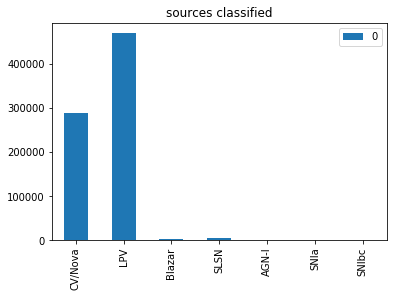

In [27]:
letter_counts = Counter(class_final_name_ul)
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')
#plt.yscale('log')
plt.title('sources classified')

In [ ]:

fig, ax = plt.subplots(nrows = len(prob_final_class_names_ul), figsize=(12, 20), sharex=True)
for idx, cl in enumerate(prob_final_class_names_ul):
   #print(idx, cl)
   print(idx, cl, np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.))
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 95.), c='g')
   ax[idx].axvline(1/len(prob_final_class_names_ul), c = 'k')
   ax[idx].hist(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, density=True, bins=40, lw=5, label=cl, alpha=0.8)
   ax[idx].text(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].max(), 1., " %s (%i)" % (cl, test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].shape[0]), fontsize=18, va='bottom', ha='left')

In [ ]:
feature = 'IAR_phi_2'
df_train = df_train.loc[df_train[feature]>-999] 
fig, ax = plt.subplots(nrows = len(label_order), figsize=(12, 20), sharex=True)

for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(idx, cl, np.percentile(df_train[feature][df_train['class_original']==cl].values, 50.))
   ax[idx].axvline(np.percentile(df_train[feature][df_train['class_original']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(df_train[feature][df_train['class_original']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(df_train[feature][df_train['class_original']==cl].values, 95.), c='g')
   ax[idx].axvline(1/len(prob_final_class_names_ul), c = 'k')
   ax[idx].hist(df_train[feature][df_train['class_original']==cl].values, density=False, bins=40, lw=5, label=cl, alpha=0.8)
   ax[idx].text(df_train[feature][df_train['class_original']==cl].max(), 1., " %s (%i)" % (cl, df_train[feature][df_train['class_original']==cl].shape[0]), fontsize=18, va='bottom', ha='left')
